# Imports

In [ ]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *
import lightgbm as lgb
from mlforecast import MLForecast
from utils import MyLGBMLSS

import matplotlib.pyplot as plt

# Data

In [ ]:
df = pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv", parse_dates = ['ds'])
num_boost_round = 500
eta = 1e-01
max_lag = 12
fcst_h = 12

mlf = MLForecast(
    models = {'lgb':lgb.LGBMRegressor(learning_rate=eta,
                                      n_estimators=num_boost_round,
                                      )
              },
    freq = 'MS',
    date_features=['month','quarter'],
    lags = [i for i in range(1, max_lag + 1)],
)

X, y = mlf.preprocess(
    df,
    return_X_y = True
)

# Fit the models

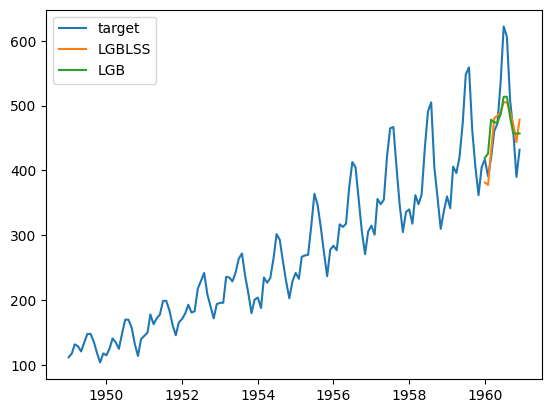

In [5]:
# Initialize the model: we mostly use standard lightgbm parameters, but LightGBMLSS usually is more sensitive to the its hyper-parameters so a time-series cross-validation is recommended
lgblss_model = MyLGBMLSS(
    dist = Gaussian(),
    params = {
        'eta': eta,
    }
)

# the model internally uses unconditional start values for the distributional parameters. This sometimes leads to early convergence, so we set the start values to 0
lgblss_model.start_values = [0,0]

# Fit the model and forecast
lgblss_model.fit(X,y)
mlf.fit(df = df.iloc[:-fcst_h])
mlf.models_['lgblss'] = lgblss_model
fcsts = mlf.predict(h = fcst_h)

# Plot the forecasts
plt.plot(df.ds,df.y,label = 'target')
plt.plot(df.ds[-fcst_h:],fcsts.lgblss,label=f'LGBLSS')
plt.plot(df.ds[-fcst_h:],fcsts.lgb, label='LGB')
plt.legend()
plt.show()

# Forecast evaluation

In [6]:
mse_lgb = ((df.y[-fcst_h:] - fcsts.lgb.values) ** 2).mean()
mse_lgbmlss = ((df.y[-fcst_h:] - fcsts.lgblss.values) ** 2).mean()

print(f"Mean Squared Error for LightGBM: {mse_lgb}")
print(f"Mean Squared Error for LightGBMLSS: {mse_lgbmlss}")

Mean Squared Error for LightGBM: 2780.9862985905224
Mean Squared Error for LightGBMLSS: 2787.7107508670692
